In [196]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.stats import lognorm
from scipy.interpolate import interp1d
import csv
from tqdm import tqdm

import matplotlib as mpl
import seaborn as sns
custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 1,
    "figure.dpi": 300,
    "text.usetex": False,
    "font.family": "serif",
    "axes.linewidth": 2,
    "xtick.major.width": 2,
    "ytick.major.width": 2,
    "xtick.minor.width": 2,
    "ytick.minor.width": 2,
}

sns.set_theme(context="notebook", style="ticks", rc=custom_params)

In [197]:
# Paramètres physiques
k_b = 1.38e-23          # constante de Boltzmann (J/K)
temp = 300          # température (K)
g = 9.81              # gravité (m/s²)
a = 1.5e-6              # rayon de la particule (m)
eta0 = 1e-3          # viscosité
rho_p = 1050.0         # densité particule (kg/m3)
rho_fluide = 1000.0     # densité fluide (kg/m3)
D0 = k_b * temp / (6 * np.pi * eta0 * a) 

# Longueurs caractéristiques
l_d = 21e-9          # longueur de Debye (m)
l_b = 530e-9
#l_b = k_b * temp / (4/3*np.pi*(1.5e-6 ** 3) * 50 * 9.81)
B = 4.8     # en Joules

dt = 0.01      # pas de temps (s)
Ndt = 1000000 # nombre d'étapes

# Position initiale
x0 = 0.0

### Simulation trajectoire

#### Fonctions 

In [198]:
# Viscosité

def eta_z(z):
    
    eta_z = eta0 * (6 * z**2 + 9*a*z + 2*a**2)/(6*z**2 + 2*a*z)
    
    return eta_z

def eta_x(z):
    
    eta_x = eta0 * (1 
                    - ((9*a)/(16 *(z+a))) 
                    + ((1*a**3) / (8 * (z+a)**3 )) 
                    - ((45*a**4)/(256 * (z+a)**4)) 
                    - (1 * a**5 /(16 * (z+a)**5))
                   )**-1
    return eta_x 

In [199]:
# Coefficient de diffusion

def mu_x(z):
    return 1 / (6 * np.pi * eta_x(z) * a)

def mu_z(z):
    return 1 / (6 * np.pi * eta_z(z) * a)

def D_x(z):
      return k_b * temp * mu_x(z)

def D_z(z):
      return k_b * temp * mu_z(z)

In [200]:
def _Peq(z):
    if z <= 0:
        return 0
    else:
        return np.exp(-(B * np.exp(-z / l_d) + z / l_b))

def Peq(z):
    z = np.asarray(z)  # transforme z en tableau si besoin
    P = np.vectorize(_Peq)(z)  # applique _Peq élément par élément
    if P.ndim > 0:  # normalise seulement si c'est un tableau
        P = P / np.trapz(P, z)
    return P


In [201]:
z = np.zeros(1000)
z_th = np.linspace(1e-9, 2e-6, 1000)

def sample(z_sample, Peq):
    z_p = Peq(z_sample)
    cdf = np.cumsum(z_p)
    cdf = cdf/cdf.max() 
    inverse_cdf = interp1d(cdf,z_sample) 
    return inverse_cdf

inverse_cdf = sample(z_th, Peq)

z[0] = inverse_cdf(np.random.uniform(0.000000000001, (1-0.000000000001)))
z0 = z[0]

print(z0)



8.691655407326937e-07


In [202]:
# Force verticale (selon z)
def force_z(z): 
    return -k_b * temp / l_b + k_b * temp*(B / l_d) * np.exp(-z / l_d)


In [203]:
def v_spurious(z):
    eps = 1e-9
    return (D_z(z + eps) - D_z(z - eps )) / (2 * eps)


#### Simulation

In [204]:
contact_count = 0

def move_particle_x_z(x, z, dt,alpha):
    global contact_count
    Dx = D_x(z)
    Dz = D_z(z)
    mux = mu_x(z)
    muz = mu_z(z)
    
    xip1 = x + np.random.normal(0, np.sqrt(2*Dx*dt)) 
    zip1 = z + np.random.normal(0, np.sqrt(2*Dz*dt)) + muz * force_z(z) * dt + alpha *  v_spurious(z) * dt

    if zip1 < 0:
        zip1 = 1.5e-6
        contact_count += 1 

    return xip1, zip1

def sim_trajectoire(Ndt,alpha):
    x = x0
    z = z0
    x_traj = [x]
    z_traj = [z]
    for i in range(Ndt):
        x ,z = move_particle_x_z (x ,z ,dt,alpha)
        x_traj.append(x)  
        z_traj.append(z)
    return np.array(x_traj) , np.array(z_traj)

x_traj , z_traj = sim_trajectoire(Ndt,1) #avec spurious drift
x_traj2 , z_traj2 = sim_trajectoire(Ndt,0)
L = np.sum(z_traj < a)

print("Nombre de contacts avec la paroi :", L)
print("Nombre de fois où z < 0 :", contact_count)

Nombre de contacts avec la paroi : 922701
Nombre de fois où z < 0 : 301


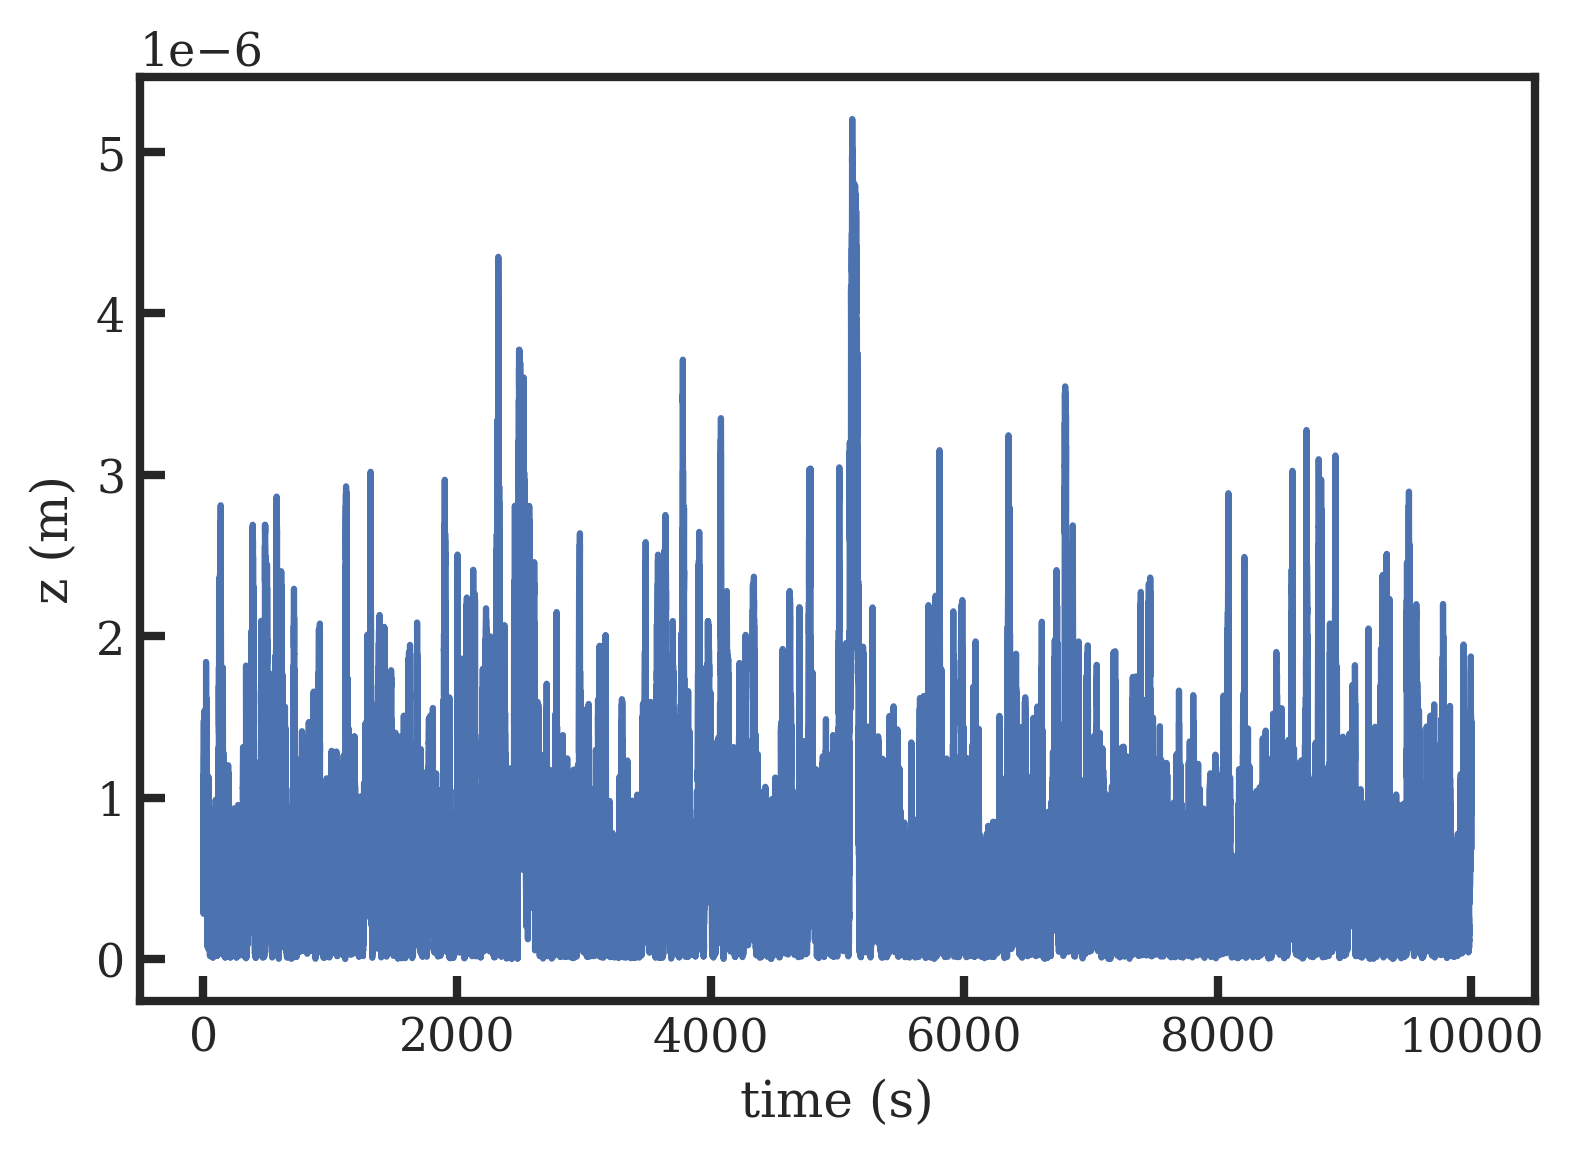

In [205]:
t = np.arange(len(z_traj)) * dt

plt.figure(figsize=(6,4))
plt.plot(t, z_traj)
plt.xlabel("time (s)")
plt.ylabel("z (m)")
plt.savefig('Trajectoire_z_zoomed.pdf')
plt.show()


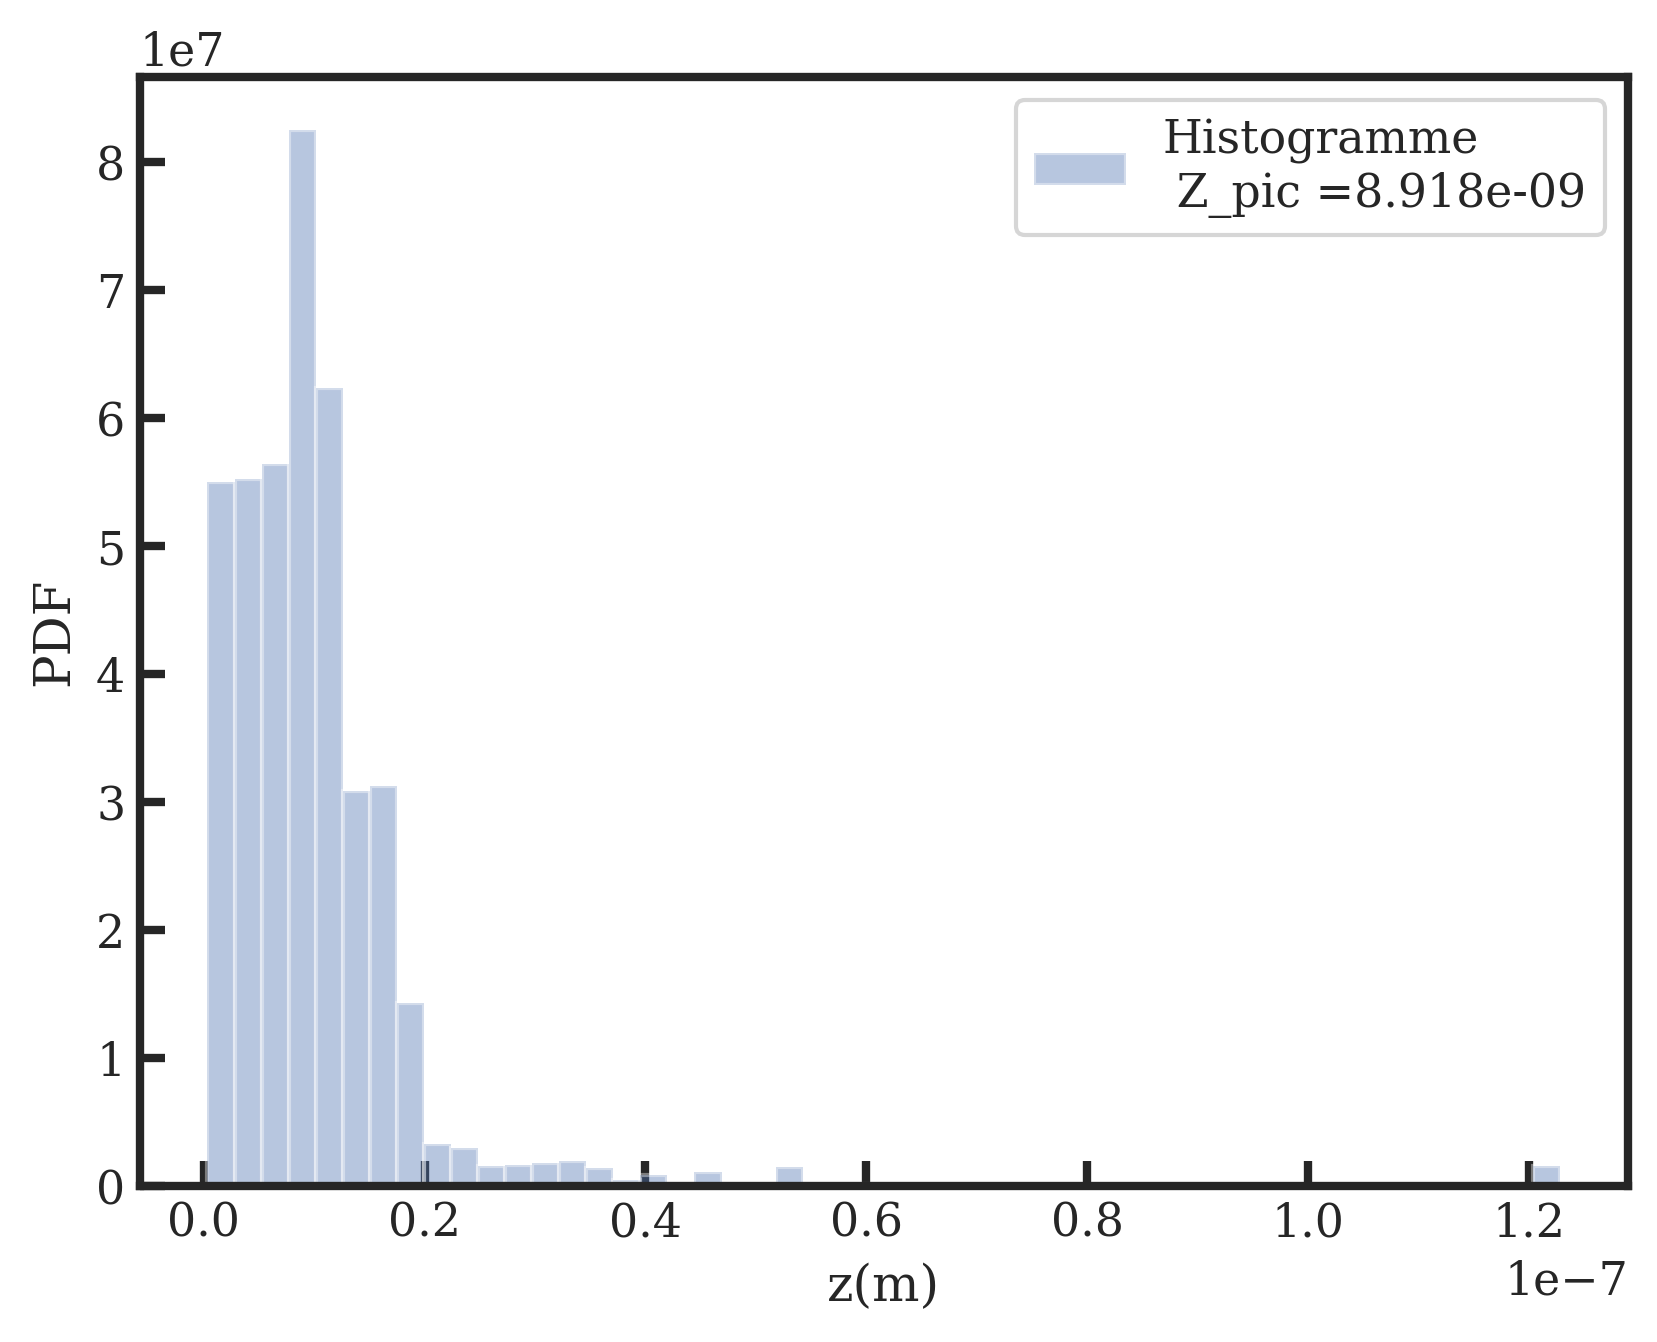

In [206]:
def movmin(z, window):
    result = np.empty_like(z)
    start_pt = 0
    end_pt = int(np.ceil(window / 2))

    for i in range(len(z)):
        if i < int(np.ceil(window / 2)):
            start_pt = 0
        if i > len(z) - int(np.ceil(window / 2)):
            end_pt = len(z)
        result[i] = np.min(z[start_pt:end_pt])
        start_pt += 1
        end_pt += 1

    return result

m = movmin(z_traj,10000)

#Calcul de FWHM numériquement

def fwhm_numeric(data, bins=50):
    # Histogramme
    n, bins = np.histogram(data, bins=bins, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Pic et demi-hauteur
    peak_idx = np.argmax(n)
    z_peak = bin_centers[peak_idx]
    half_max = n[peak_idx] / 2

    # Indices autour de la demi-hauteur
    above = np.where(n >= half_max)[0]
    if len(above) >= 2:
        fwhm = bin_centers[above[-1]] - bin_centers[above[0]]
    else:
        fwhm = np.nan

    return fwhm, z_peak

fwhm_n, z_peak = fwhm_numeric(m)
plt.hist(m, bins=50, density=True, alpha=0.4, label=f'Histogramme\n Z_pic ={z_peak:.3e}')
plt.xlabel('z(m)')
plt.ylabel('PDF')
plt.legend()
plt.savefig('PDF_minima.pdf')
plt.show()

In [207]:
s = z_traj
# Données : local_min extrait depuis z_traj
local_min = [s[idx] for idx in range(1, len(s)-1) if s[idx-1] > s[idx] < s[idx+1]]

#Calcul de FWHM numériquement

def fwhm_numeric(data, bins=50):
    # Histogramme
    n, bins = np.histogram(data, bins=bins, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Pic et demi-hauteur
    peak_idx = np.argmax(n)
    z_peak = bin_centers[peak_idx]
    half_max = n[peak_idx] / 2

    # Indices autour de la demi-hauteur
    above = np.where(n >= half_max)[0]
    if len(above) >= 2:
        fwhm = bin_centers[above[-1]] - bin_centers[above[0]]
    else:
        fwhm = np.nan

    return fwhm, z_peak

fwhm_n, z_peak = fwhm_numeric(local_min)

print(f"FWHM numérique : {fwhm_n:.4e} m")
print(f"z_pic   : {z_peak:.4e} m")

# Calcul de plusieurs données

Min = np.min(local_min)
Max = np.max(local_min)
mean_min = np.mean(local_min)
std_min = np.std(local_min)
effectif = len(local_min)

print('Nombre de minima locaux :', effectif)
print('Min absolu :', Min)
print('Max des minima locaux :', Max)
print('Moyenne :', mean_min)
print('Écart-type :', std_min)

FWHM numérique : 4.0638e-07 m
z_pic   : 1.5273e-07 m
Nombre de minima locaux : 250081
Min absolu : 3.4314219207951505e-10
Max des minima locaux : 5.080054885781685e-06
Moyenne : 5.979584758112953e-07
Écart-type : 5.766938204817003e-07


### MSD

#### Fonctions

In [210]:
# MSD
def MSD(x, t):
    msd = np.zeros(len(t))
    for n, i in enumerate(t):
        msd[n] = np.nanmean((x[:-i] - x[i:]) ** 2)
    return msd

##### Calcul du MSD théorique 

In [211]:
t = np.concatenate([
    np.arange(10, 100, 10),
    np.arange(100, 1000, 100),
    np.arange(1000, 10000, 1000),
    np.arange(10000, 100000, 10000),
    np.arange(100000, 1000000, 100000)
])

In [212]:
z = np.linspace(1e-9, 2e-6, 1000)

P = Peq(z) 

Dx_vals = D_x(z)
Dz_vals = D_z(z)

D_x_mean = np.trapz(Dx_vals * P, z)
D_z_mean = np.trapz(Dz_vals * P, z)


MSD_x_m = 2 * D_x_mean * t * dt
MSD_z_m = 2 * D_z_mean * t * dt


#### Courbe du MSD

In [213]:
N = 5

liste_MSD_x = []
liste_MSD_z = []

for _ in tqdm(range(N), desc="Simulation en cours"):
        x_traj, z_traj = sim_trajectoire(Ndt,1)
        MSD_x = MSD(x_traj , t)
        MSD_z = MSD(z_traj, t)
        liste_MSD_x.append(MSD_x)
        liste_MSD_z.append(MSD_z)
    
liste_MSD_x = np.array(liste_MSD_x)
msd_mean_x = np.mean(liste_MSD_x, axis=0)
msd_std_x = np.std(liste_MSD_x, axis=0)
msd_err_x = msd_std_x / np.sqrt(N)

liste_MSD_z = np.array(liste_MSD_z)  
msd_mean_z = np.mean(liste_MSD_z, axis=0)
msd_std_z = np.std(liste_MSD_z, axis=0)
msd_err_z = msd_std_z / np.sqrt(N)


Simulation en cours: 100%|██████████| 5/5 [01:39<00:00, 19.92s/it]


In [214]:
def fonction(t, A, alpha):
    return A * t**alpha


t_plateau = 10000
fit_plateau = t >= t_plateau
t_fit_plateau = t[fit_plateau]

msd_z_fit_plateau = msd_mean_z[fit_plateau]

popt, _ = curve_fit(fonction, t_fit_plateau, msd_z_fit_plateau)
Az, alpha = popt
fit = fonction(t, Az, alpha)

x = popt[0]
print('Plateau avec curve_fit : ', x)

plateau = np.mean(msd_mean_z[t > 1e4])
print('Plateau : ', plateau)

Plateau avec curve_fit :  4.4646113521269783e-13
Plateau :  5.517629460376707e-13


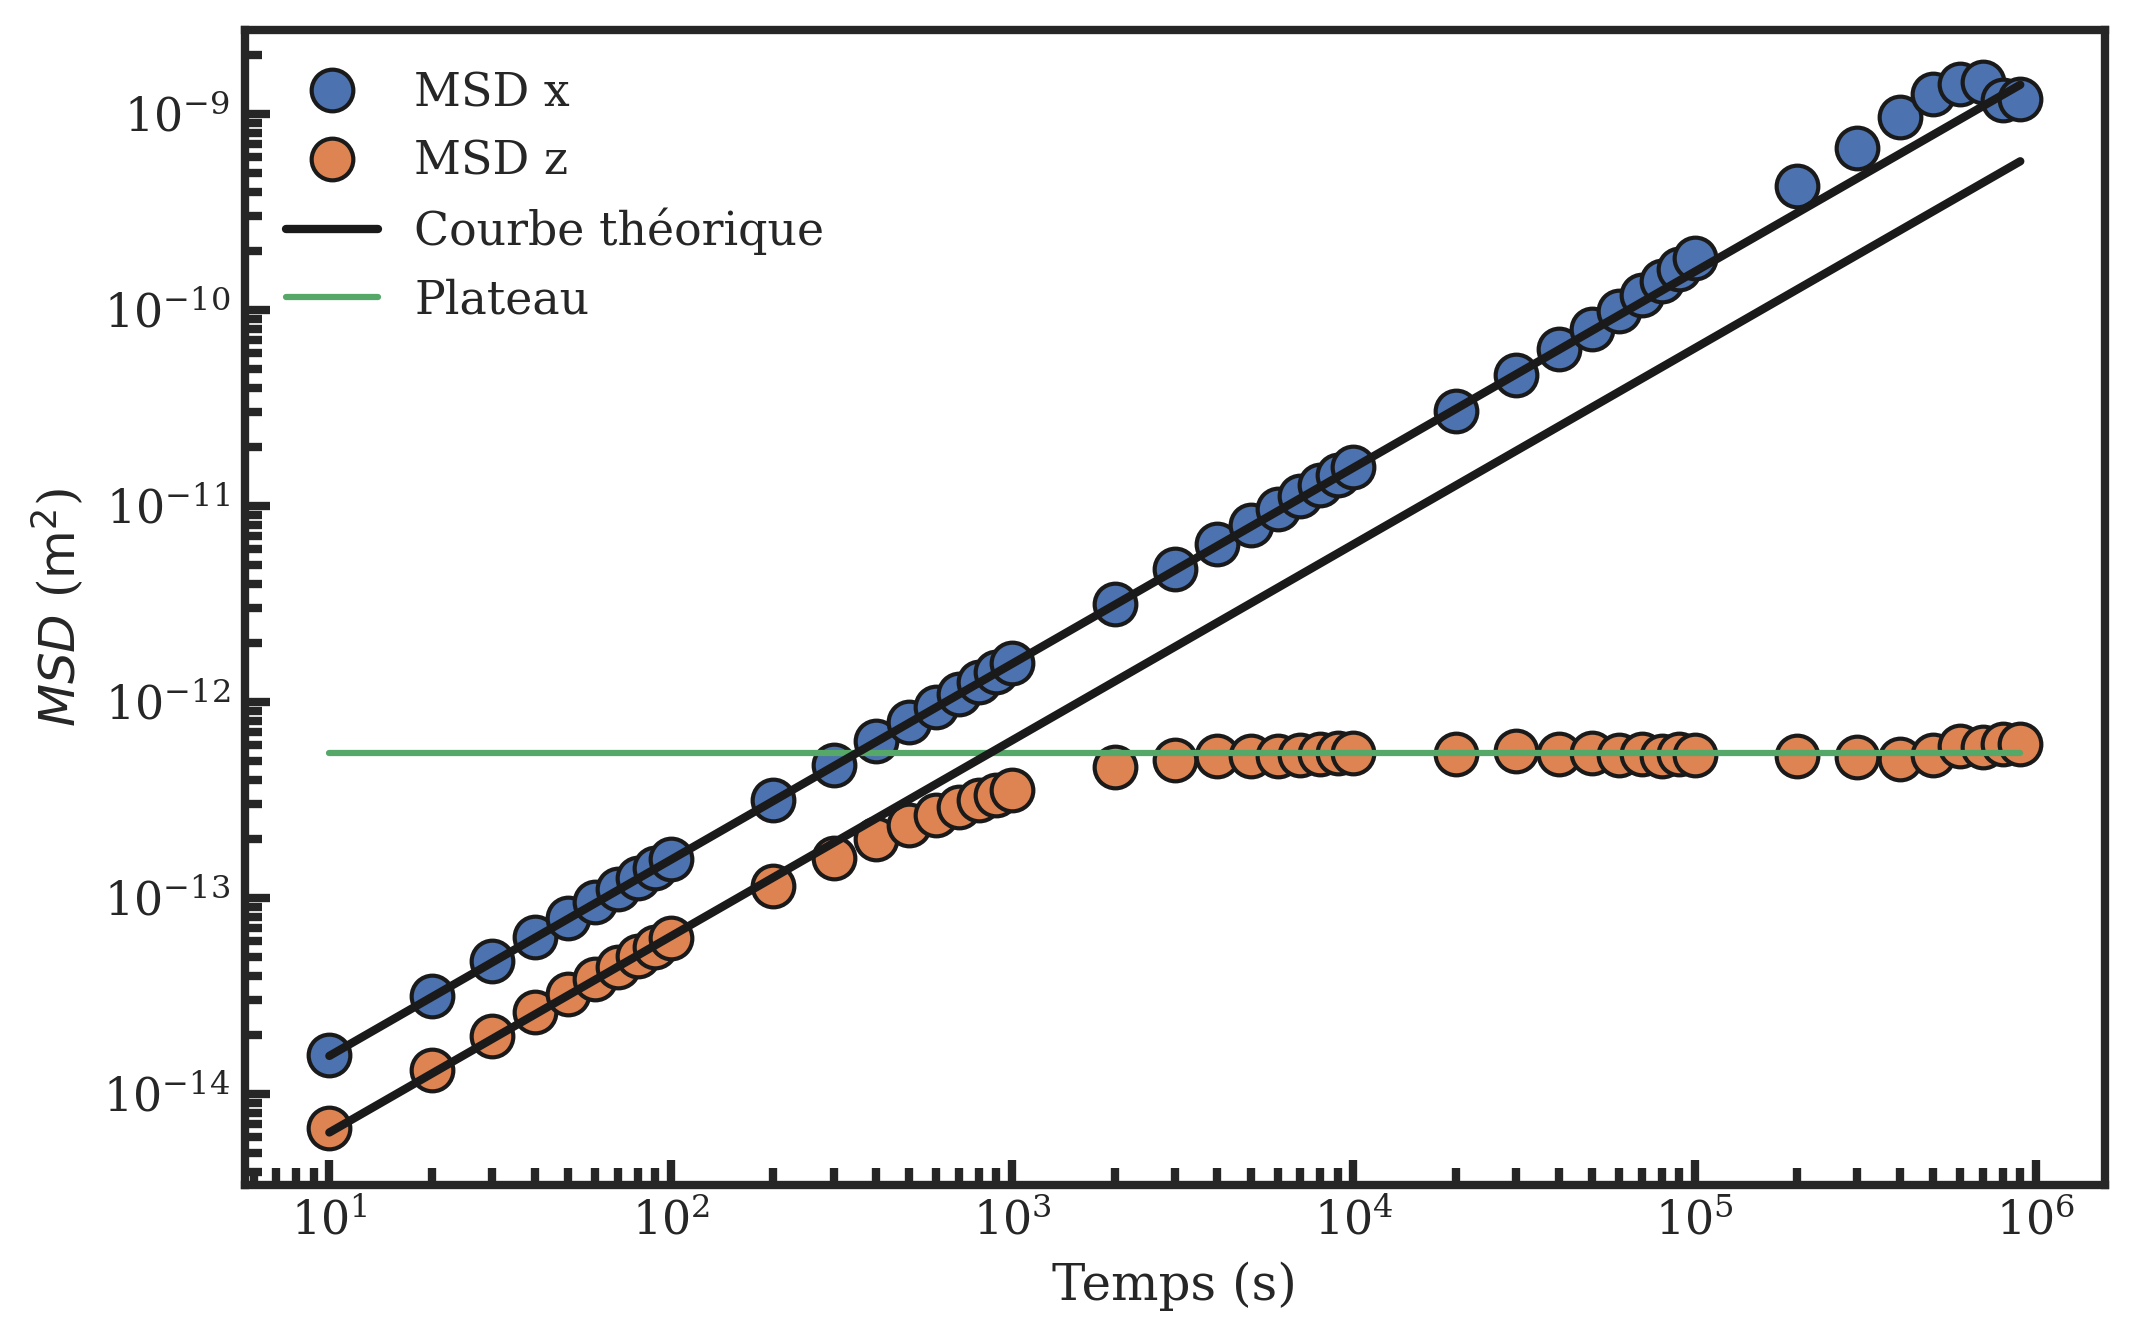

In [215]:
plt.figure(figsize=(8, 5))
plt.loglog(t, msd_mean_x,'o' ,markersize = 10, label="MSD x")
plt.loglog(t, msd_mean_z, 'o',markersize = 10, label="MSD z")
plt.plot(t, MSD_x_m,color = "k",linewidth=2, zorder =10, label = 'Courbe théorique')
plt.plot(t, MSD_z_m,color = "k",linewidth=2, zorder =10)
plt.plot(t,[plateau]* len(t),label='Plateau')

plt.xlabel("Temps (s)")
plt.ylabel("$MSD$ ($\mathrm{ m  ^{2}}$)")
plt.legend(frameon = False)
plt.savefig('MSD_X_Z.pdf')
plt.show()

## PDF

#### Fonction

In [216]:
def calcul_pdf(data, bins = 30, density = True):
    
    pdf, bins_edge = np.histogram(data, bins = bins, density = density)
    bins_center = (bins_edge[0:-1] + bins_edge[1:]) / 2
    
    return pdf, bins_center


In [217]:
z = np.linspace(1e-9, 5e-6, 1000) 
bins = np.linspace(1e-9, 5e-6, 50)
pdf, bins= calcul_pdf(z_traj, bins=bins)

#### Courbe du pdf

In [218]:
N = 5
liste_pdf = []

for _ in tqdm(range(N), desc="Simulation en cours"):
        _, z_traj = sim_trajectoire(Ndt, 1)
        pdf, bins_center = calcul_pdf(z_traj, bins=bins)
        liste_pdf.append(pdf)

liste_pdf = np.array(liste_pdf)  # shape: (N, nb_bins)
pdf_mean = np.mean(liste_pdf, axis=0)
pdf_std = np.std(liste_pdf, axis=0)
pdf_err = pdf_std / np.sqrt(N)



Simulation en cours: 100%|██████████| 5/5 [01:39<00:00, 19.84s/it]


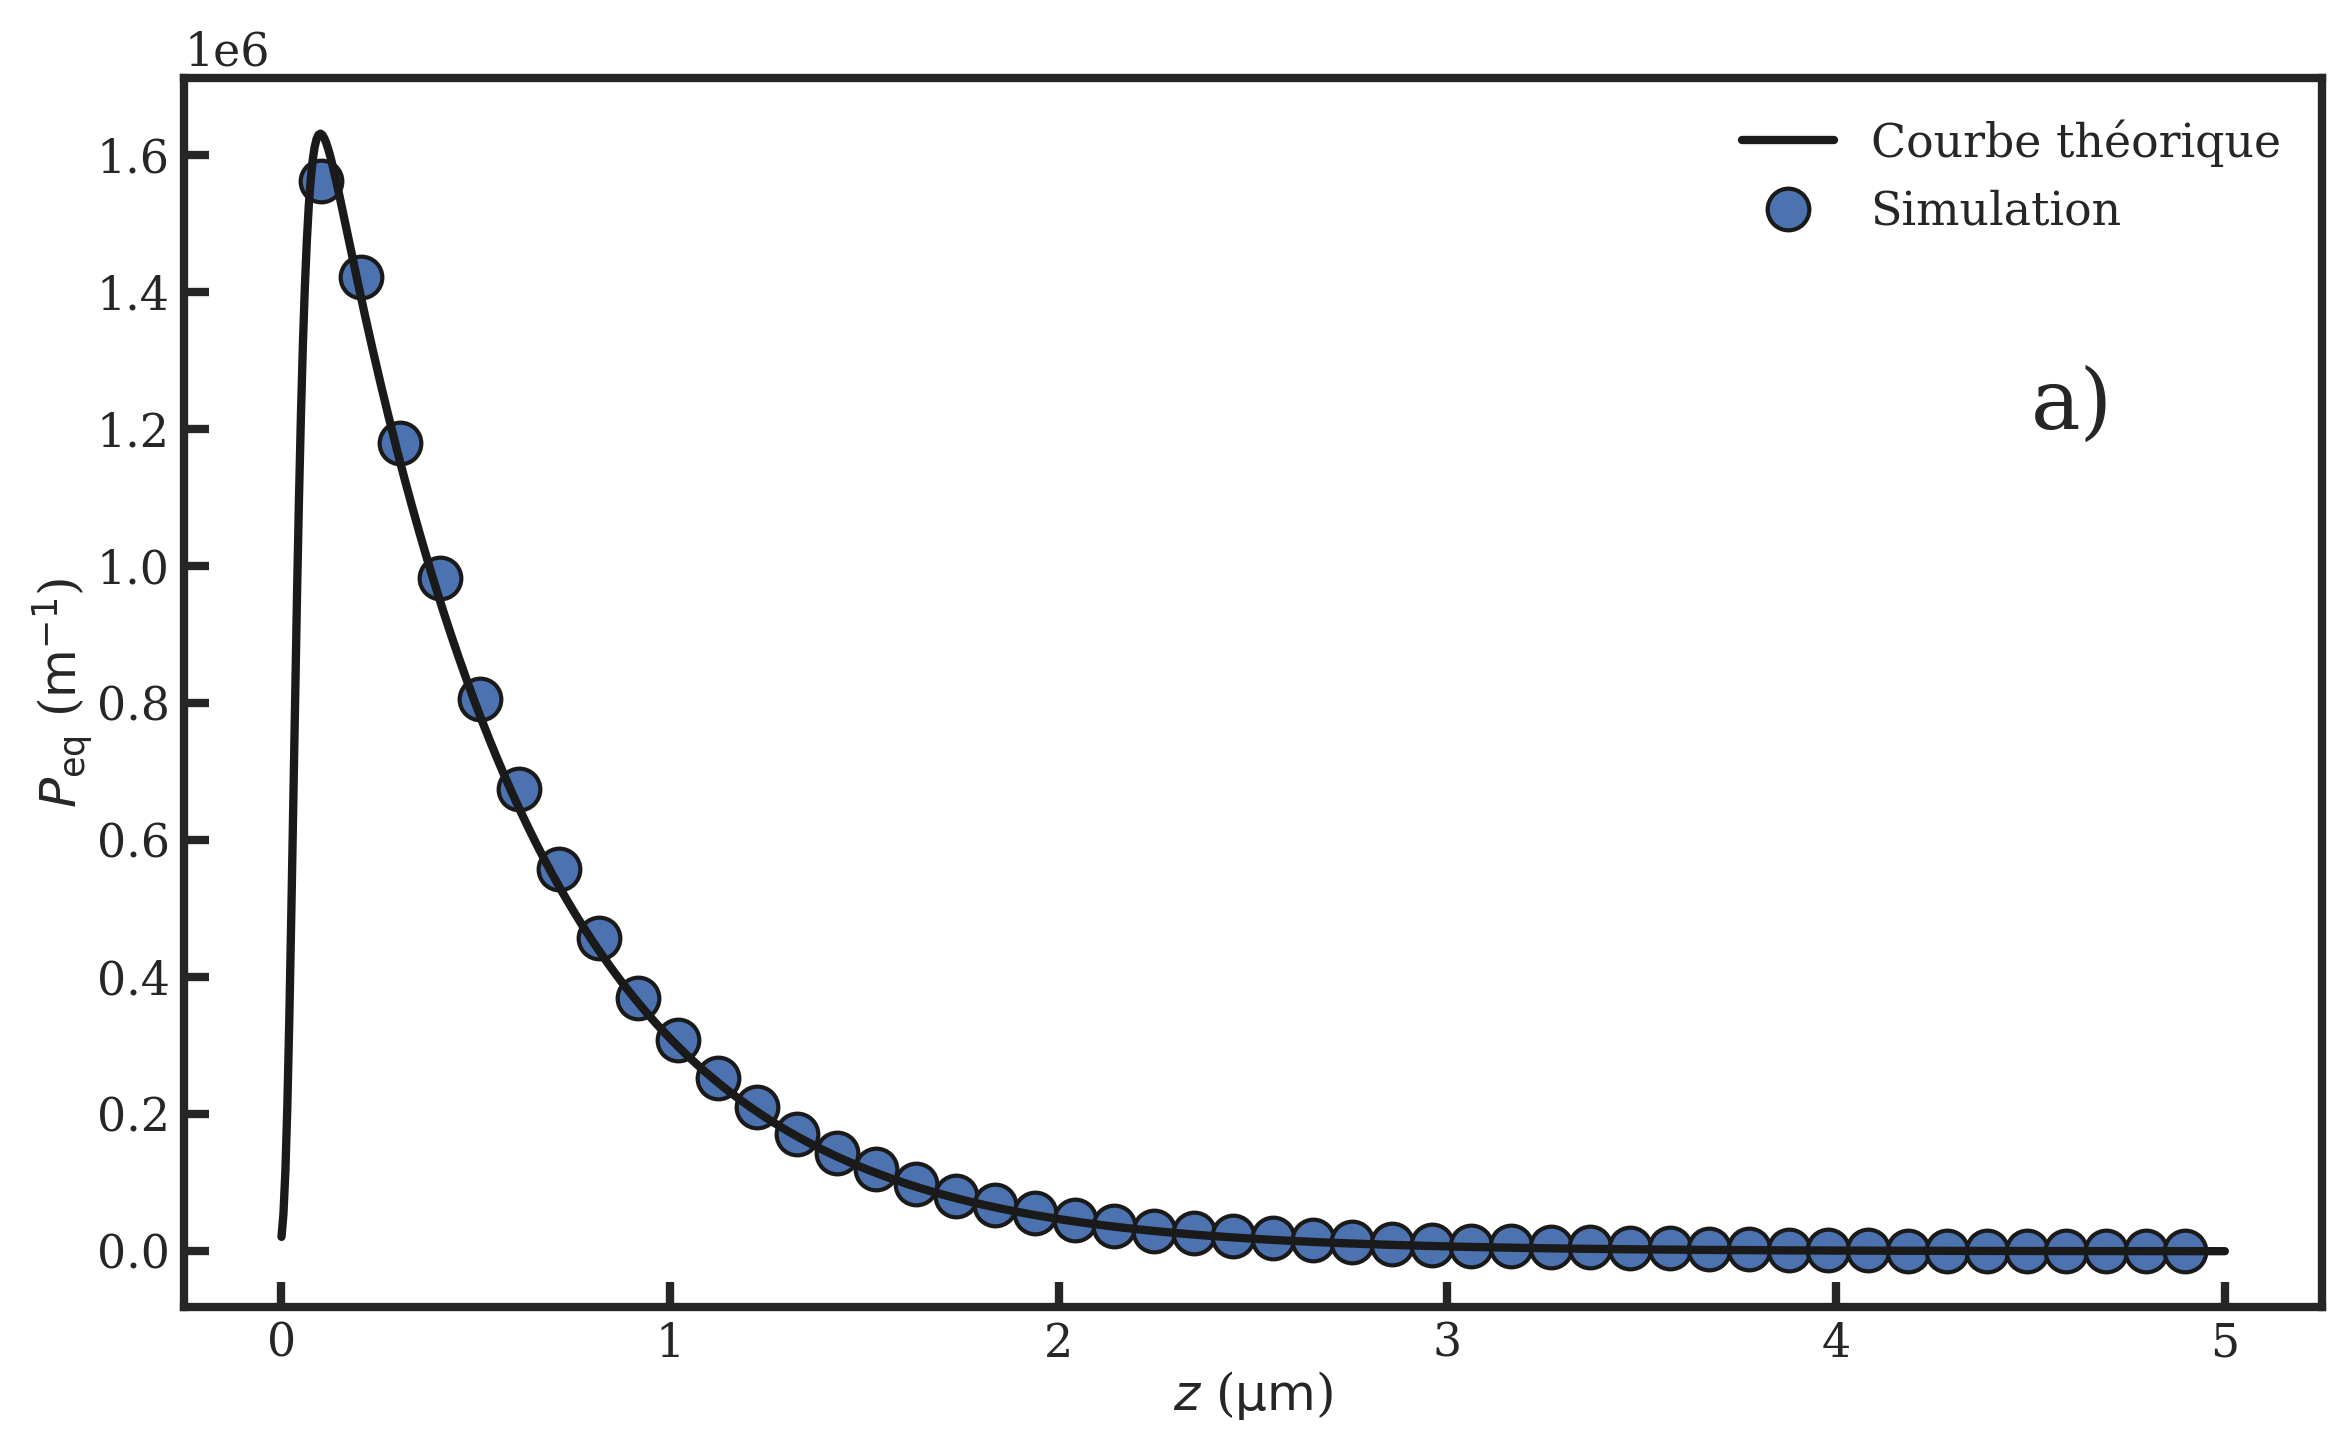

In [245]:
plt.figure(figsize=(8, 5))
plt.plot(z * 1e6, Peq(z), color = "k",linewidth=2, zorder =10, label = 'Courbe théorique')
plt.plot(bins_center * 1e6, pdf_mean,'o',markersize = 10, label ='Simulation')
plt.xlabel("$z$ ($\mathrm{\mu m}$)", labelpad=0.5)
plt.ylabel("$P_{\mathrm{eq}}$ ($\mathrm{ m  ^{-1}}$)", labelpad=0.5)
plt.text(4.5,1.2e6,'a)',fontsize = 20)
plt.tight_layout()
plt.legend(frameon = False)
plt.savefig('PDF_de_z.pdf')
plt.show()

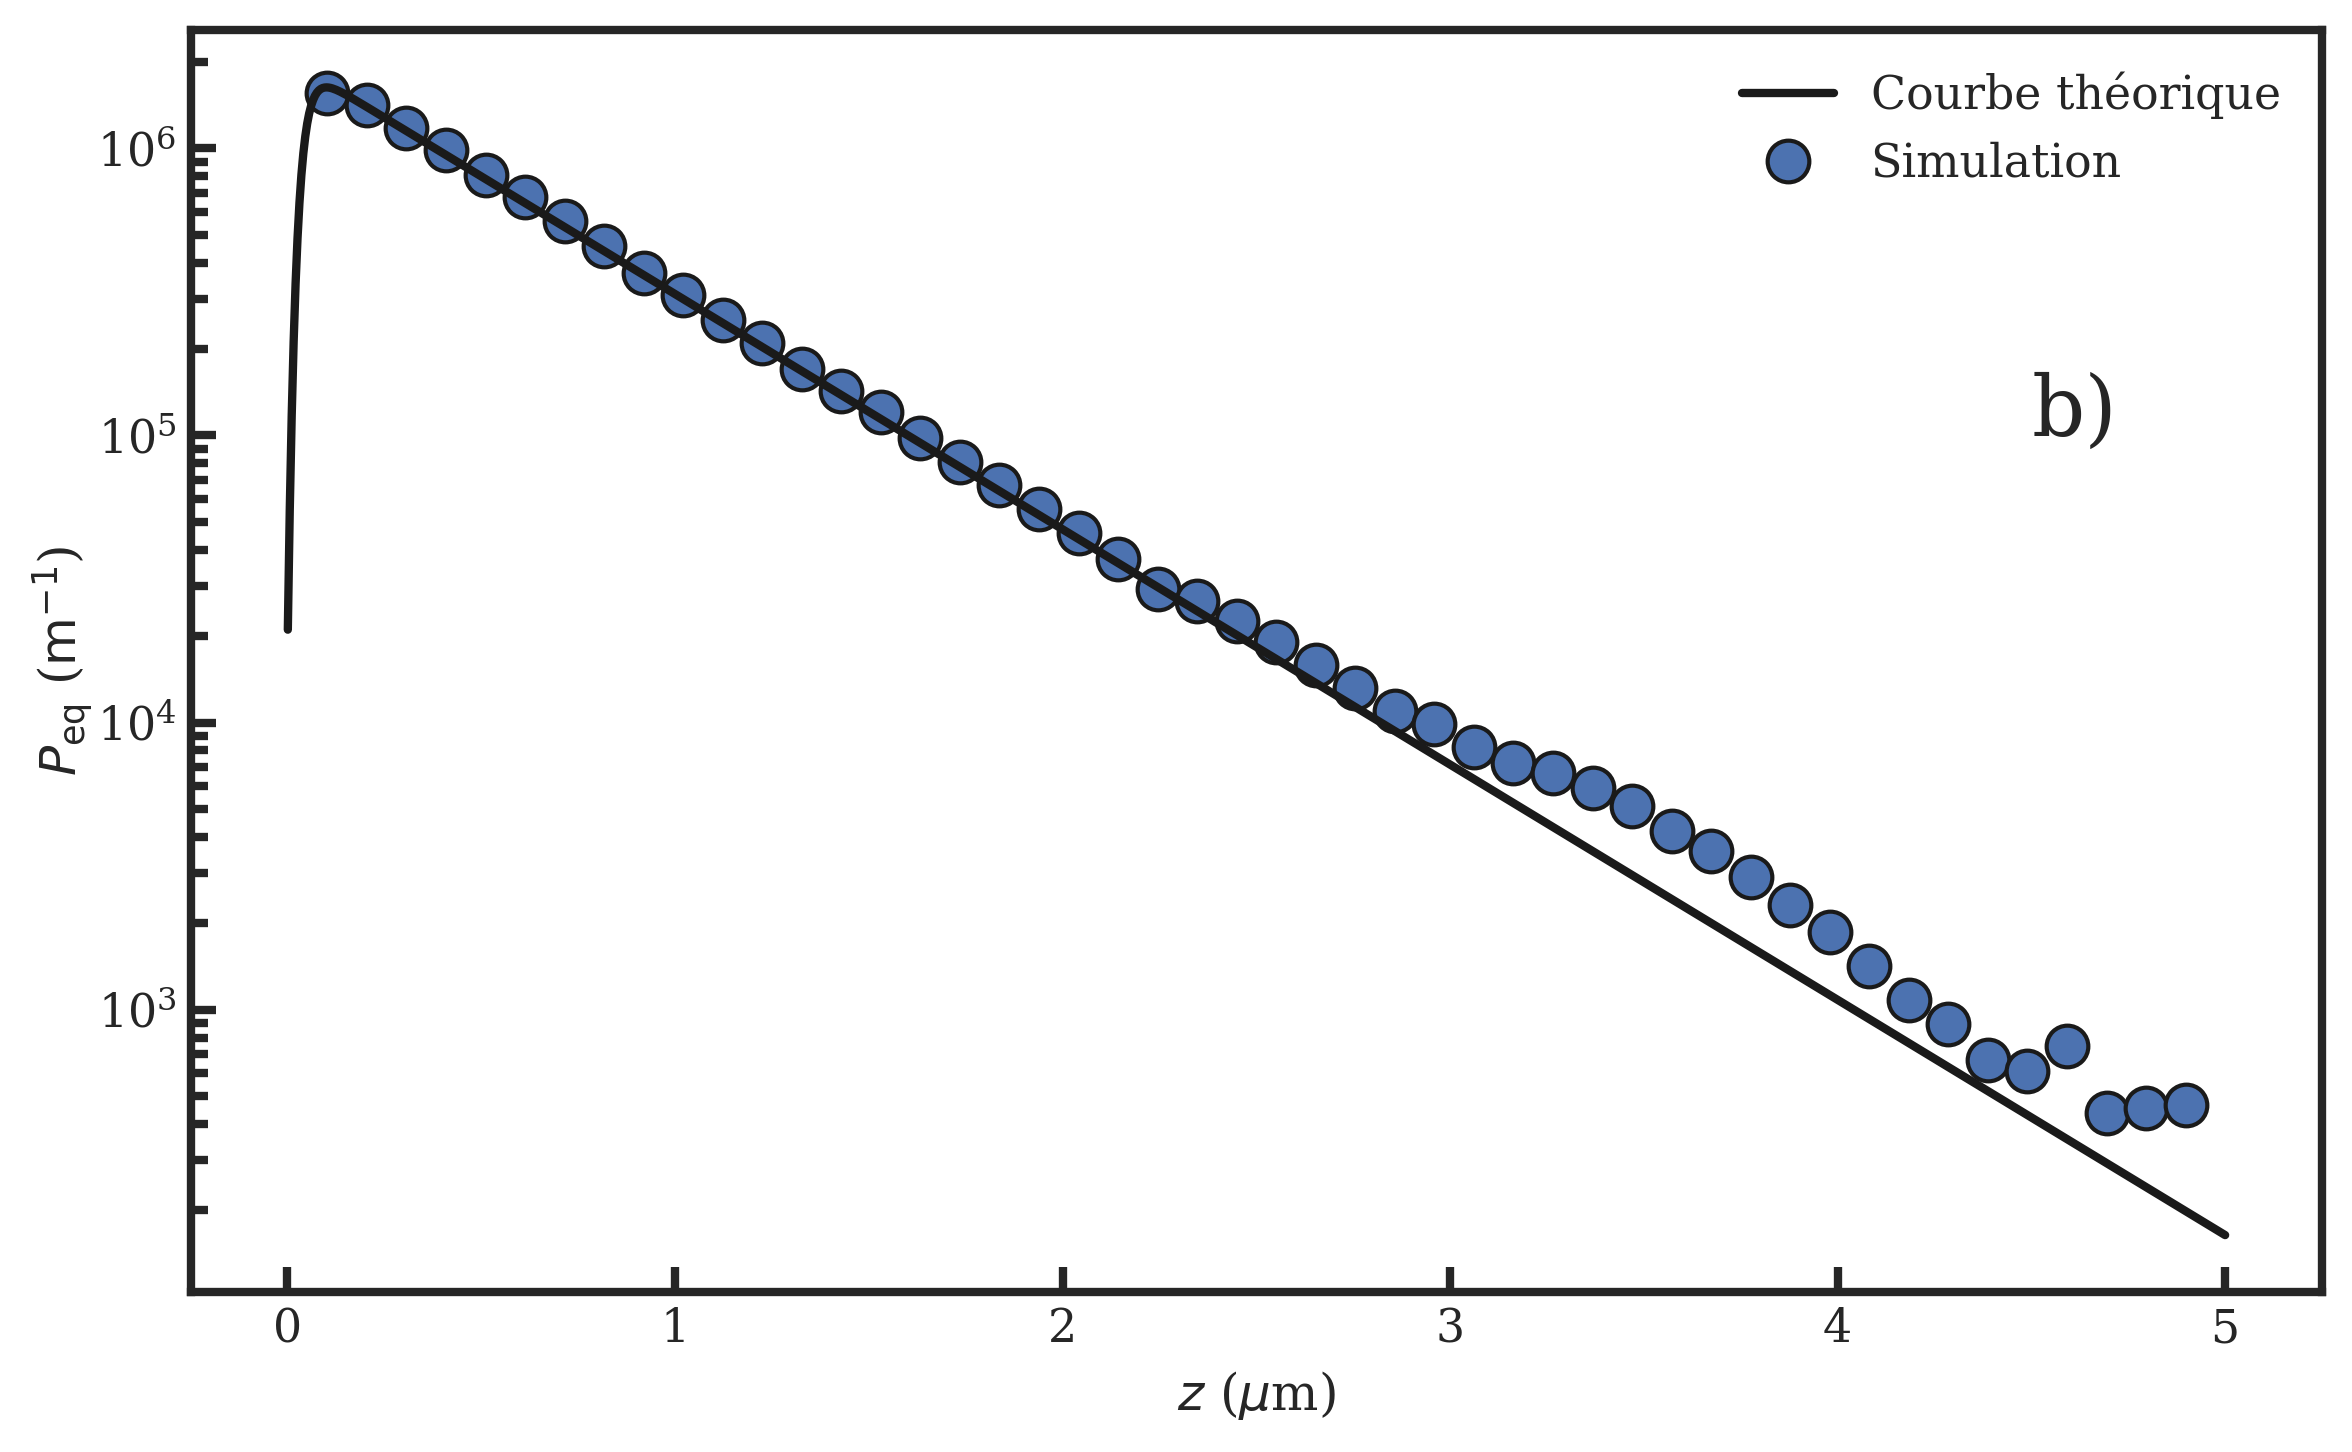

In [250]:
# Tracé
plt.figure(figsize=(8, 5))
plt.semilogy(z * 1e6, Peq(z), color = "k",linewidth=2, zorder =10, label = 'Courbe théorique')
plt.plot(bins_center * 1e6, pdf_mean,'o',markersize = 10, label ='Simulation')
plt.xlabel("$z$ ($\mu$m)")
plt.ylabel("$P_{\mathrm{eq}}$ ($\mathrm{ m  ^{-1}}$)", labelpad=0.5)
plt.text(4.5,1e5,'b)',fontsize = 20)
plt.tight_layout()
plt.legend(frameon = False)
plt.savefig('PDF_moyenne.pdf')
plt.show()


# 